In [76]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import math
import pathlib
import pickle
from itertools import combinations
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats

from sklearn import metrics, neighbors, linear_model, preprocessing, svm
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold, StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)

In [178]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                #print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            #print('\nSubj/Visit %d,prec=%.3f,rec=%.3f,Spec=%.3f,auroc_train=%.3f,auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 
                          'auroc':np.nanmean(auroc_all)},index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 




def LOSOMultiClass(Data,X,y,groups,model,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','RMS'])
    groupres = {} #results on each group for each model
    
    acc_all=[]; acc_train=[] 
    f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
    auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]
    RMS_all = []
    
    clf = model[0][0]; model_name = model[0][1]          
    print('Training %s'%model_name)
    s = 0
    #LOSO CV for current classifier
    for train_index, test_index in subj.split(X, y, groups):
    #leave one in:
        if LOin:
            tridx = train_index.copy()
            train_index = test_index.copy()
            test_index = tridx
        Xtr, Xte = X[train_index], X[test_index]
        ytr, yte = y[train_index], y[test_index]
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            #print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        
        RMS=0
        for yp,yt in zip(ypred,y):
            RMS += ((yp - yt)**2)
        RMS = RMS / len(y)
        RMS = math.sqrt(RMS)
        
        RMS_all.append(RMS)
        
        groupres[model_name] = {'RMS':RMS_all}
        
        r = pd.DataFrame({'model':model_name, 'RMS':np.nanmean(RMS_all)},index=[0])
        results = pd.concat((results,r))
        
    return results, groupres

In [145]:
featdict = {'freq':['Dom_freq','Pdom_rel','PSD_mean','PSD_std','PSD_skew','PSD_kur'],
            'time':['RMSX','RMSY','RMSZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ','skewX','skewY','skewZ','kurtX','kurtY','kurtZ','Sen_X','Sen_Y','Sen_Z'],
            'corr':['xcorr_peakXZ','xcorr_peakYZ','xcor_peakXY','xcorr_lagXZ','xcorr_lagYZ','xcorr_lagXY'],
            'jerk':['jerk_mean','jerk_std','jerk_skew','jerk_kur'],
            'mag' :['RMS_mag','range_mag','mean_mag','var_mag','skew_mag','kurt_mag','Sen_mag']}

In [191]:
data = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data 62.5Hz.csv',index_col=0)
data = data[(data.Subject!=1030) & (data.Subject!=1020)]
data.head()
np.unique(data.Subject)

array([1004, 1016, 1018, 1019, 1024, 1029, 1032, 1038, 1044, 1046, 1049,
       1051], dtype=int64)

In [140]:
mag_features_tremor = []
xyz_features_tremor = []
mag_features_brady = []
xyz_features_brady = []
info = ['Subject','Visit','Task','Bradykinesia','Tremor']
mag_features = featdict['freq'] + featdict['jerk'] + featdict['mag']
xyz_features =  featdict['freq'] + featdict['time'] + featdict['jerk'] + featdict['corr']
for f in range(len(mag_features)):
    mag_features_tremor.append(mag_features[f] + ' acc')
    mag_features_brady.append(mag_features[f] + ' acc')
for f in range(len(mag_features)):
    mag_features_brady.append(mag_features[f] + ' gyr')
for f in range(len(xyz_features)):
    xyz_features_tremor.append(xyz_features[f] + ' acc')
    xyz_features_brady.append(xyz_features[f] + ' acc')
for f in range(len(xyz_features)):
    xyz_features_brady.append(xyz_features[f] + ' gyr')
data_tremor_mag = data[info + mag_features_tremor]
data_tremor_xyz = data[info + xyz_features_tremor]
data_brady_mag = data[info + mag_features_brady]
data_brady_xyz = data[info + xyz_features_brady]

In [248]:
t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = data_tremor_xyz.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
fnames = Data.iloc[:,5:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.340+/-0.217, prec=0.478+/-0.297, rec=0.299+/-0.177, auprc=0.482+/-0.264, auroc=0.708+/-0.161
Elapsed time = 0.832 min


Text(0.5,1,'LOSO Tremor XYZ - Mean AUROC = 0.708 +/- 0.161')

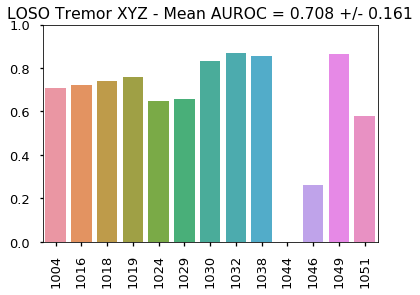

In [249]:
results_tremor_xyz = res_group['Random Forest']['auroc']
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0,1.0])
plt.title('LOSO Tremor XYZ - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

In [250]:
t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = data_tremor_mag.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
fnames = Data.iloc[:,5:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.345+/-0.220, prec=0.477+/-0.298, rec=0.317+/-0.177, auprc=0.486+/-0.268, auroc=0.709+/-0.123
Elapsed time = 0.616 min


Text(0.5,1,'LOSO Tremor MAG - Mean AUROC = 0.709 +/- 0.123')

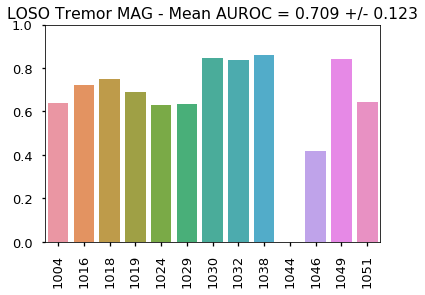

In [251]:
results_tremor_mag = res_group['Random Forest']['auroc']
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0,1.0])
plt.title('LOSO Tremor MAG - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

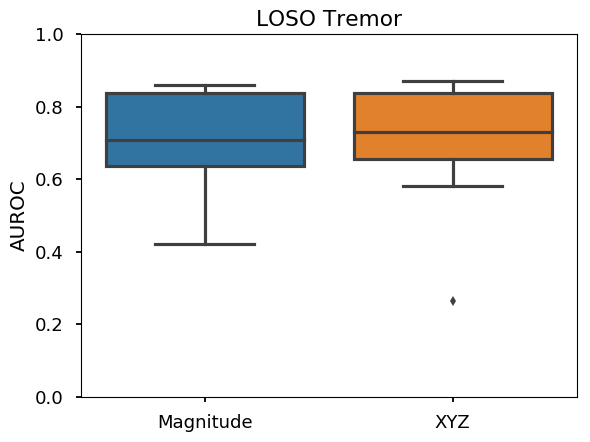

In [252]:
results = pd.DataFrame({'XYZ':results_tremor_xyz,'Magnitude':results_tremor_mag})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0,1);
plt.title('LOSO Tremor');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

In [253]:
stats.ttest_rel(results['XYZ'],results['Magnitude'])

C:\Users\Public\Documents\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Public\Documents\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Public\Documents\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Ttest_relResult(statistic=nan, pvalue=nan)

In [254]:
t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = data_brady_xyz.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
fnames = Data.iloc[:,5:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 7686/13739 = 0.56
Training Random Forest
f1_test=0.622+/-0.224, prec=0.622+/-0.283, rec=0.747+/-0.133, auprc=0.656+/-0.266, auroc=0.667+/-0.096
Elapsed time = 0.947 min


Text(0.5,1,'LOSO Bradykinesia XYZ - Mean AUROC = 0.667 +/- 0.096')

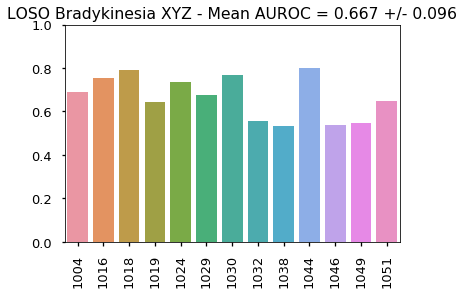

In [255]:
results_brady_xyz = res_group['Random Forest']['auroc']
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0,1.0])
plt.title('LOSO Bradykinesia XYZ - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

In [256]:
t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = data_brady_mag.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
fnames = Data.iloc[:,5:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 7686/13739 = 0.56
Training Random Forest
f1_test=0.607+/-0.223, prec=0.617+/-0.282, rec=0.725+/-0.143, auprc=0.648+/-0.272, auroc=0.659+/-0.077
Elapsed time = 0.658 min


Text(0.5,1,'LOSO Bradykinesia MAG - Mean AUROC = 0.659 +/- 0.077')

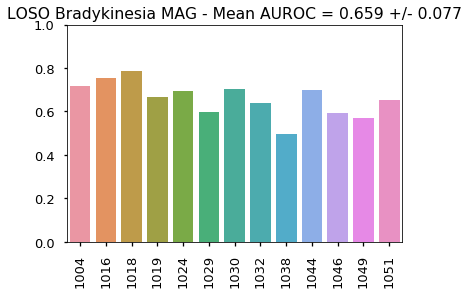

In [257]:
results_brady_mag = res_group['Random Forest']['auroc']
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0,1.0])
plt.title('LOSO Bradykinesia MAG - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

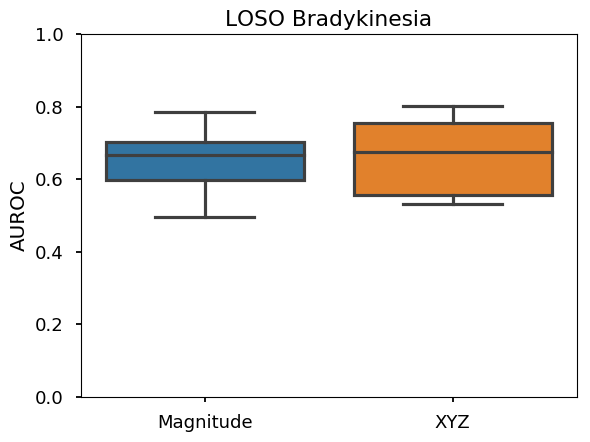

In [258]:
results = pd.DataFrame({'XYZ':results_brady_xyz,'Magnitude':results_brady_mag})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0,1);
plt.title('LOSO Bradykinesia');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

In [259]:
stats.ttest_rel(results['XYZ'],results['Magnitude'])

Ttest_relResult(statistic=0.5803583994067892, pvalue=0.572410182328439)

# Feature Combinations

In [286]:
featdict = {'freq':['Dom_freq','Pdom_rel','PSD_mean','PSD_std','PSD_skew','PSD_kur'],
            'time':['RMSX','RMSY','RMSZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ','skewX','skewY','skewZ','kurtX','kurtY','kurtZ','Sen_X','Sen_Y','Sen_Z'],
            'corr':['xcorr_peakXZ','xcorr_peakYZ','xcor_peakXY','xcorr_lagXZ','xcorr_lagYZ','xcorr_lagXY'],
            'jerk':['jerk_mean','jerk_std','jerk_skew','jerk_kur'],
            'mag' :['RMS_mag','range_mag','mean_mag','var_mag','skew_mag','kurt_mag','Sen_mag']}

In [260]:
lst = ['freq','time','corr','jerk','mag']
combs = []
for i in range(len(lst)):
    j = i + 1
    els = [list(x) for x in combinations(lst, j)]
    combs.extend(els)

In [261]:
combs

[['freq'],
 ['time'],
 ['corr'],
 ['jerk'],
 ['mag'],
 ['freq', 'time'],
 ['freq', 'corr'],
 ['freq', 'jerk'],
 ['freq', 'mag'],
 ['time', 'corr'],
 ['time', 'jerk'],
 ['time', 'mag'],
 ['corr', 'jerk'],
 ['corr', 'mag'],
 ['jerk', 'mag'],
 ['freq', 'time', 'corr'],
 ['freq', 'time', 'jerk'],
 ['freq', 'time', 'mag'],
 ['freq', 'corr', 'jerk'],
 ['freq', 'corr', 'mag'],
 ['freq', 'jerk', 'mag'],
 ['time', 'corr', 'jerk'],
 ['time', 'corr', 'mag'],
 ['time', 'jerk', 'mag'],
 ['corr', 'jerk', 'mag'],
 ['freq', 'time', 'corr', 'jerk'],
 ['freq', 'time', 'corr', 'mag'],
 ['freq', 'time', 'jerk', 'mag'],
 ['freq', 'corr', 'jerk', 'mag'],
 ['time', 'corr', 'jerk', 'mag'],
 ['freq', 'time', 'corr', 'jerk', 'mag']]

## Tremor

In [262]:
data = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel Data 62.5Hz.csv')
info = ['Subject','Visit','Task','Bradykinesia','Tremor']

In [263]:
data.head()

,Unnamed: 0,Subject,Visit,Task,Bradykinesia,Tremor,RMSX,RMSY,RMSZ,rangeX,...,Sen_X,Sen_Y,Sen_Z,RMS_mag,range_mag,mean_mag,var_mag,skew_mag,kurt_mag,Sen_mag
0,0,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000732,0.000535,0.000574,0.079929,...,0.895181,1.171897,0.991753,0.001073,0.043022,0.016731,0.008983,0.808057,0.057535,1.120104
1,1,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000591,0.000492,0.000475,0.059164,...,0.952226,0.906698,1.149938,0.000904,0.051198,0.013692,0.008266,1.536889,3.505034,0.986897
2,2,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000557,0.000494,0.000422,0.063106,...,0.890457,0.892128,1.325102,0.000856,0.051198,0.012841,0.008026,1.685300,4.507400,0.992065
3,3,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000472,0.000360,0.000383,0.056094,...,1.015921,1.299535,1.247401,0.000706,0.033267,0.011194,0.005552,0.993716,1.383678,1.393774
4,4,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000317,0.000244,0.000281,0.033473,...,1.289370,1.392917,1.263504,0.000489,0.022742,0.007503,0.004322,1.095023,1.027263,1.426254


In [387]:
symptom = 'Tremor'
t1 = time.time()
tremor_res_all = pd.DataFrame()
results_tremor = []


for comb in combs:
    
    feat_cols = []
    comb_group = ''
    
    for features_set in comb:
        
        comb_group += features_set[0]
        feat_cols = feat_cols + featdict[features_set]
    
    data_comb = data[info + feat_cols]

    Data = data_comb.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res['Combination'] = comb_group
    tremor_res_all = pd.concat((tremor_res_all,res))
    results_tremor.append(res_group)

tremor_res_all = tremor_res_all.reset_index(drop=True)

print('Elapsed time = %.3f min'%((time.time()-t1)/60))   

Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.248+/-0.134, prec=0.421+/-0.269, rec=0.208+/-0.111, auprc=0.408+/-0.239, auroc=0.619+/-0.098
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.357+/-0.229, prec=0.501+/-0.302, rec=0.306+/-0.189, auprc=0.505+/-0.264, auroc=0.708+/-0.150
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.275+/-0.172, prec=0.463+/-0.316, rec=0.225+/-0.150, auprc=0.475+/-0.248, auroc=0.644+/-0.156
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.288+/-0.186, prec=0.475+/-0.314, rec=0.266+/-0.155, auprc=0.469+/-0.249, auroc=0.645+/-0.138
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.362+/-0.196, prec=0.494+/-0.294, rec=0.351+/-0.162, auprc=0.499+/-0.255, auroc=0.716+/-0.122
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.355+/-0.225, prec=0.507+/-0.298, rec=0.302+/-0.186, auprc=0.514+/-0.254, auroc=0.720+/-0.141
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.277+/-0.184, prec=0.473+/-0.314, rec=0.227+/-0.158, auprc=0.480+/-0.247, auroc=0.649+/-0.166
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.335+/-0.223, prec=0.502+/-0.303, rec=0.299+/-0.180, auprc=0.490+/-0.257, auroc=0.696+/-0.129
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.364+/-0.203, prec=0.504+/-0.289, rec=0.343+/-0.166, auprc=0.505+/-0.252, auroc=0.723+/-0.120
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.364+/-0.235, prec=0.510+/-0.304, rec=0.305+/-0.204, auprc=0.527+/-0.262, auroc=0.712+/-0.157
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.369+/-0.244, prec=0.514+/-0.309, rec=0.314+/-0.214, auprc=0.528+/-0.264, auroc=0.724+/-0.150
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.362+/-0.223, prec=0.511+/-0.301, rec=0.310+/-0.188, auprc=0.527+/-0.255, auroc=0.722+/-0.138
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.366+/-0.238, prec=0.528+/-0.329, rec=0.310+/-0.198, auprc=0.532+/-0.271, auroc=0.695+/-0.180
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.365+/-0.220, prec=0.514+/-0.308, rec=0.309+/-0.198, auprc=0.526+/-0.262, auroc=0.709+/-0.154
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.372+/-0.232, prec=0.515+/-0.307, rec=0.334+/-0.193, auprc=0.521+/-0.263, auroc=0.732+/-0.124
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.357+/-0.234, prec=0.506+/-0.298, rec=0.304+/-0.208, auprc=0.522+/-0.258, auroc=0.716+/-0.155
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.357+/-0.240, prec=0.514+/-0.307, rec=0.306+/-0.203, auprc=0.525+/-0.261, auroc=0.722+/-0.146
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.363+/-0.231, prec=0.514+/-0.304, rec=0.306+/-0.200, auprc=0.515+/-0.264, auroc=0.713+/-0.145
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.347+/-0.230, prec=0.517+/-0.310, rec=0.298+/-0.192, auprc=0.520+/-0.262, auroc=0.703+/-0.164
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.356+/-0.220, prec=0.518+/-0.300, rec=0.297+/-0.201, auprc=0.519+/-0.258, auroc=0.721+/-0.138
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.364+/-0.225, prec=0.518+/-0.301, rec=0.331+/-0.183, auprc=0.517+/-0.262, auroc=0.731+/-0.118
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.376+/-0.244, prec=0.530+/-0.313, rec=0.320+/-0.206, auprc=0.534+/-0.266, auroc=0.724+/-0.149
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.376+/-0.234, prec=0.530+/-0.310, rec=0.320+/-0.206, auprc=0.529+/-0.263, auroc=0.724+/-0.142
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.373+/-0.243, prec=0.514+/-0.312, rec=0.317+/-0.215, auprc=0.525+/-0.266, auroc=0.725+/-0.143
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.372+/-0.236, prec=0.529+/-0.316, rec=0.316+/-0.211, auprc=0.538+/-0.270, auroc=0.724+/-0.152
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.365+/-0.244, prec=0.519+/-0.310, rec=0.309+/-0.215, auprc=0.526+/-0.267, auroc=0.712+/-0.161
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.375+/-0.234, prec=0.528+/-0.300, rec=0.319+/-0.210, auprc=0.533+/-0.258, auroc=0.723+/-0.142
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.366+/-0.237, prec=0.509+/-0.302, rec=0.317+/-0.203, auprc=0.516+/-0.262, auroc=0.724+/-0.139
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.369+/-0.235, prec=0.530+/-0.308, rec=0.313+/-0.211, auprc=0.531+/-0.264, auroc=0.727+/-0.140
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.383+/-0.247, prec=0.537+/-0.312, rec=0.325+/-0.219, auprc=0.536+/-0.265, auroc=0.732+/-0.146
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.360+/-0.239, prec=0.509+/-0.304, rec=0.306+/-0.213, auprc=0.525+/-0.261, auroc=0.721+/-0.144
Elapsed time = 25.267 min


f: frequency
t: time
c: correlation
j: jerk
m: mag


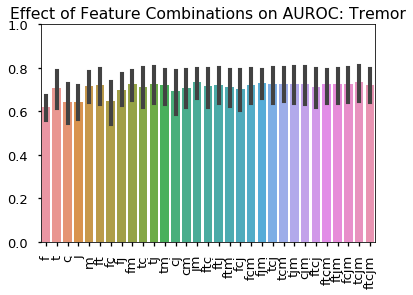

In [388]:
groups = tremor_res_all['Combination'].values
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(results_tremor)):
    if len(results_tremor[i]['Random Forest']['auroc']) < 7:
        L = len(results_tremor[i]['Random Forest']['auroc'])
        results_tremor[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[groups[i]] = results_tremor[i]['Random Forest']['auroc']   
    tremor_auc = results_tremor[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(tremor_auc)) #mean across visits
    auc_std.append(np.nanstd(tremor_auc))

sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.ylim([0,1])
plt.title('Effect of Feature Combinations on AUROC: Tremor')
plt.figure(figsize=(10,20))
print('f: frequency')
print('t: time')
print('c: correlation')
print('j: jerk')
print('m: mag')

In [389]:
tremor_res_all

,auprc,auroc,f1,model,Combination
0,0.407909,0.618644,0.247864,Random Forest,f
1,0.504586,0.707797,0.356776,Random Forest,t
2,0.474927,0.644345,0.274602,Random Forest,c
3,0.469196,0.644744,0.287824,Random Forest,j
4,0.499358,0.715707,0.362482,Random Forest,m
5,0.513666,0.720097,0.355372,Random Forest,ft
6,0.479633,0.649046,0.277197,Random Forest,fc
7,0.490147,0.696131,0.334850,Random Forest,fj
8,0.505131,0.722994,0.364445,Random Forest,fm
9,0.527234,0.711733,0.363678,Random Forest,tc


In [407]:
x = results_tremor[5]['Random Forest']['auroc']
x = np.array(x)
x = x[~np.isnan(x)]
x
#print(~np.isnan(x))

array([0.68705906, 0.72402392, 0.75870264, 0.74647926, 0.66777001,
       0.67884642, 0.83661884, 0.87316622, 0.83799784, 0.35146525,
       0.88637507, 0.59265802])

In [390]:
x = results_tremor[1]['Random Forest']['auroc']
x.remove(np.nan)
for featgroup in [0,2,3,4,30]:
    print('t, %s'%tremor_res_all.iloc[featgroup]['Combination'])
    y = results_tremor[featgroup]['Random Forest']['auroc']
    y.remove(np.nan)
    print(stats.ttest_rel(x,y))

t, f
Ttest_relResult(statistic=2.9520593570825002, pvalue=0.013160839253705413)
t, c
Ttest_relResult(statistic=3.973195983935057, pvalue=0.002184108603888074)
t, j
Ttest_relResult(statistic=2.877180719434898, pvalue=0.01504698367904931)
t, m
Ttest_relResult(statistic=-0.7037784264782391, pvalue=0.4961986246578832)
t, ftcjm
Ttest_relResult(statistic=-3.21763211895602, pvalue=0.008193510905407165)


## Bradykinesia

In [391]:
def fix_feature_names(features):
    if features[0][-3:] != 'acc':
        featlen = len(features)
        for f in range(featlen):
            features.append(features[f] + ' gyr')
        for f in range(featlen):
            features[f] = features[f] + ' acc'

In [392]:
featdictsensors = featdict

for featgroup in featdictsensors.keys():
    fix_feature_names(featdictsensors[featgroup])

info = ['Subject','Visit','Task','Bradykinesia','Tremor']
data = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data 62.5Hz.csv')

In [393]:
symptom = 'Bradykinesia'
t1 = time.time()
brady_res_all = pd.DataFrame()
results_brady = []


for comb in combs:
    
    feat_cols = []
    comb_group = ''
    
    for features_set in comb:
        
        comb_group += features_set[0]
        feat_cols = feat_cols + featdict[features_set]
    
    data_comb = data[info + feat_cols]

    Data = data_comb.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res['Combination'] = comb_group
    brady_res_all = pd.concat((brady_res_all,res))
    results_brady.append(res_group)

brady_res_all = brady_res_all.reset_index(drop=True)

print('Elapsed time = %.3f min'%((time.time()-t1)/60))   

Training Random Forest
f1_test=0.587+/-0.214, prec=0.608+/-0.281, rec=0.694+/-0.125, auprc=0.631+/-0.271, auroc=0.632+/-0.066
Training Random Forest
f1_test=0.619+/-0.221, prec=0.624+/-0.282, rec=0.741+/-0.140, auprc=0.656+/-0.268, auroc=0.684+/-0.092
Training Random Forest
f1_test=0.595+/-0.230, prec=0.600+/-0.285, rec=0.713+/-0.137, auprc=0.603+/-0.283, auroc=0.605+/-0.091
Training Random Forest
f1_test=0.588+/-0.209, prec=0.598+/-0.278, rec=0.706+/-0.093, auprc=0.604+/-0.274, auroc=0.607+/-0.089
Training Random Forest
f1_test=0.597+/-0.216, prec=0.609+/-0.276, rec=0.708+/-0.139, auprc=0.639+/-0.273, auroc=0.642+/-0.078
Training Random Forest
f1_test=0.623+/-0.221, prec=0.622+/-0.279, rec=0.752+/-0.130, auprc=0.647+/-0.272, auroc=0.675+/-0.092
Training Random Forest
f1_test=0.602+/-0.224, prec=0.608+/-0.283, rec=0.723+/-0.127, auprc=0.606+/-0.276, auroc=0.618+/-0.084
Training Random Forest
f1_test=0.590+/-0.220, prec=0.609+/-0.283, rec=0.694+/-0.125, auprc=0.635+/-0.274, auroc=0.639+

f: frequency
t: time
c: correlation
j: jerk
m: mag


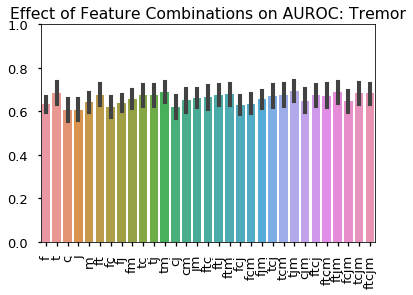

In [394]:
groups = brady_res_all['Combination'].values
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(results_brady)):
    if len(results_brady[i]['Random Forest']['auroc']) < 7:
        L = len(results_brady[i]['Random Forest']['auroc'])
        results_brady[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[groups[i]] = results_brady[i]['Random Forest']['auroc']   
    brady_auc = results_brady[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(brady_auc)) #mean across visits
    auc_std.append(np.nanstd(brady_auc))

sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.ylim([0,1])
plt.title('Effect of Feature Combinations on AUROC: Tremor')
plt.figure(figsize=(10,20))
print('f: frequency')
print('t: time')
print('c: correlation')
print('j: jerk')
print('m: mag')

In [395]:
brady_res_all

,auprc,auroc,f1,model,Combination
0,0.630701,0.632089,0.586916,Random Forest,f
1,0.656331,0.684018,0.618779,Random Forest,t
2,0.603255,0.604636,0.594942,Random Forest,c
3,0.603737,0.606584,0.588478,Random Forest,j
4,0.638723,0.642443,0.597445,Random Forest,m
5,0.647476,0.675406,0.622546,Random Forest,ft
6,0.606340,0.617514,0.601981,Random Forest,fc
7,0.634780,0.638861,0.590448,Random Forest,fj
8,0.646465,0.656462,0.609897,Random Forest,fm
9,0.651410,0.674001,0.618932,Random Forest,tc


In [399]:
x = results_brady[1]['Random Forest']['auroc']
for featgroup in [0,2,3,4,30]:
    print('t, %s'%brady_res_all.iloc[featgroup]['Combination'])
    y = results_brady[featgroup]['Random Forest']['auroc']
    print(stats.ttest_rel(x,y))

t, f
Ttest_relResult(statistic=2.6028692494911065, pvalue=0.023103384581561356)
t, c
Ttest_relResult(statistic=4.613935279434423, pvalue=0.0005964012838987744)
t, j
Ttest_relResult(statistic=3.715166318015009, pvalue=0.0029528158425049526)
t, m
Ttest_relResult(statistic=2.4779628117665853, pvalue=0.029066385231013094)
t, ftcjm
Ttest_relResult(statistic=0.30640699303426594, pvalue=0.7645460305972742)
